# Pressure: An Observational Study 😨

Hypothesis: Higher pressure situations lessen the likelihood of field goal conversion.

In [2]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('..')

import pandas as pd
import numpy as np
import mysql.connector
import itertools
import dtale
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime as dt
from util.data import clean, get_data

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load & Clean

In [3]:
cnx = mysql.connector.connect(user='root', password='mOntie20!mysql', host='127.0.0.1', database='nfl')
df = get_data(cnx, 'g.seas<=2019', xp=False, base='raw_6_cat')
df = clean(df, dropna=False)
df

,fkicker,good,dist,year,seasons,temperature,home_team,stadium,team,XP,...,humid,wind,away_game,postseason,iced,turf,precipitation,pressure,form,kicks
pid,,,,,,,,,,,,,,,,,,,,,
2166,AD-0800,1,38,2000,17,73,BUF,Ralph Wilson Stadium,TEN,0,...,1,10,1,0,0,1,0,1,0.764708,765
2185,AD-0800,1,27,2000,17,73,BUF,Ralph Wilson Stadium,TEN,0,...,1,10,1,0,0,1,0,1,0.807721,766
4565,AD-0800,1,36,2000,17,80,TEN,Adelphia Coliseum,TEN,0,...,1,13,0,0,1,0,0,5,NaN,767
8564,AD-0800,1,24,2000,17,61,PIT,Three Rivers Stadium,TEN,0,...,0,16,1,0,0,1,1,1,0.842837,768
8628,AD-0800,1,40,2000,17,61,PIT,Three Rivers Stadium,TEN,0,...,0,16,1,0,0,1,1,1,0.871516,769
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
862982,ZG-0050,1,30,2019,3,66,ARI,State Farm Stadium,ARI,0,...,0,0,0,0,0,0,0,1,0.826709,62
865338,ZG-0050,1,21,2019,3,66,ARI,State Farm Stadium,ARI,0,...,0,11,0,0,0,0,0,2,0.858217,63
868268,ZG-0050,1,22,2019,3,43,SEA,CenturyLink Field,ARI,0,...,1,7,1,0,0,1,0,1,1.000000,64


In [4]:
df.describe()

,good,dist,year,seasons,temperature,XP,age,altitude,humid,wind,away_game,postseason,iced,turf,precipitation,pressure,form,kicks
count,18803.000000,18803.000000,18803.000000,18803.000000,18803.000000,18803.0,18803.000000,18803.000000,18803.000000,18803.000000,18803.000000,18803.000000,18803.000000,18803.000000,18803.000000,18803.000000,18710.000000,18803.000000
mean,0.844865,36.881242,2009.516992,7.913099,60.776153,0.0,29.927139,0.033771,0.352178,6.549593,0.487901,0.040845,0.125033,0.445408,0.080413,1.400202,0.844876,255.230601
std,0.362043,10.070235,5.643918,5.162924,15.706069,0.0,5.250091,0.180645,0.477662,5.986469,0.499867,0.197935,0.330765,0.497024,0.271938,1.024004,0.124109,209.053136
min,0.000000,18.000000,2000.000000,1.000000,-6.000000,0.0,22.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,28.000000,2005.000000,4.000000,51.000000,0.0,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.772214,94.000000
50%,1.000000,37.000000,2010.000000,7.000000,64.000000,0.0,29.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.865337,201.000000
75%,1.000000,45.000000,2014.000000,11.000000,70.000000,0.0,33.000000,0.000000,1.000000,10.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.945632,362.000000
max,1.000000,76.000000,2019.000000,26.000000,109.000000,0.0,47.000000,1.000000,1.000000,40.000000,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,1033.000000


## Explore

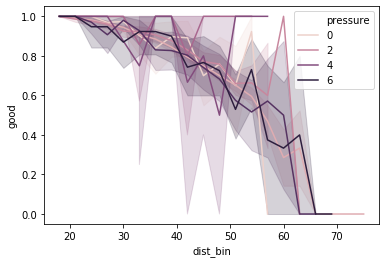

In [5]:
df_ = df.copy()
df_['dist_bin'] = 3*round(df_['dist']/3)
sns.lineplot(x='dist_bin', y='good', hue='pressure', data=df_)

In [6]:
df_long = df[df['dist']>=40].drop(['fkicker', 'home_team', 'stadium', 'team', 'XP'], axis=1)
df_long['form'] = df['form'].fillna(method='bfill')
df_long.dropna(inplace=True)
df_long

,good,dist,year,seasons,temperature,age,altitude,humid,wind,away_game,postseason,iced,turf,precipitation,pressure,form,kicks
pid,,,,,,,,,,,,,,,,,
8628,1,40,2000,17,61,38,0,0,16,1,0,0,1,1,1,0.871516,769
8652,1,40,2000,17,61,38,0,0,16,1,0,0,1,1,2,0.894946,770
11064,0,46,2000,17,72,38,0,1,5,0,0,1,0,0,1,1.000000,771
12417,1,41,2000,17,44,38,0,1,10,1,0,0,0,0,1,0.842957,773
16254,0,44,2000,17,74,38,0,0,6,0,0,0,0,0,1,0.671096,777
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
844674,1,47,2019,3,56,24,0,1,3,1,0,0,1,1,1,0.813096,52
846996,1,50,2019,3,70,24,0,0,0,1,0,0,1,0,1,0.771461,56
851666,1,54,2019,3,77,24,0,0,8,1,0,0,0,0,1,0.883073,59


1    5880
2    1379
5     295
6     201
0     160
3      15
4      15
Name: pressure, dtype: int64


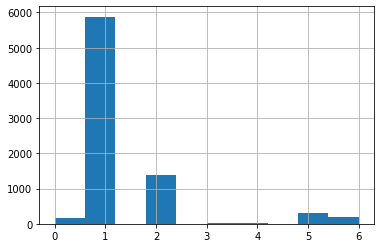

In [7]:
print(df_long['pressure'].value_counts())
df_long['pressure'].hist()

The distribution is very skewed. It may be necessary to collapse some of the categories. \[0,1\],\[2,3,4\],\[5,6\] (i.e. low, medium, high pressure)

In [8]:
df_long['pressure'] = df_long['pressure'].map({0:0, 1:0, 2:1, 3:1, 4:1, 5:2, 6:2})
print(df_long['pressure'].value_counts())

0    6040
1    1409
2     496
Name: pressure, dtype: int64


## Pair

* Mahanalobis vs Propensity score vs normal matching.
* Normal matching may result in best of one group matching only worst in the other group.
* Look into this.

First match 0 pressure with 1 pressure

In [58]:
from util.matching import match

caliper = 1.5

In [59]:
df_long01 = df_long[df_long['pressure']<2]

df_long01['pressure'] = df_long01['pressure'].astype(bool)
matches_01 = match(df_long01.drop('good', axis=1), t='pressure', distance='mahalanobis', method='with_replacement', caliper=caliper)
unique_less_01 = set(map(lambda x: x['match'], matches_01.values())) # potentially repeated "less" samples
unique_more_01 = set(matches_01.keys())
match_ids = unique_less_01.union(unique_more_01)
overlap = unique_less_01.intersection(unique_more_01)
print(len(unique_more_01), 'unique keys.', len(unique_less_01), 'unique matches.', len(overlap), 'overlapping.')
df_matched_01 = df_long.loc[match_ids, :]
df_matched_01

2831 unique keys. 980 unique matches. 0 overlapping.


,good,dist,year,seasons,temperature,age,altitude,humid,wind,away_game,postseason,iced,turf,precipitation,pressure,form,kicks
pid,,,,,,,,,,,,,,,,,
49153,1,42,2001,2,65,23,0,0,0,1,0,0,1,0,0,0.597037,77
794627,1,54,2018,4,86,27,0,1,10,0,0,0,0,0,0,0.910318,94
139270,0,53,2003,11,69,33,0,1,8,1,0,0,0,0,1,0.909596,467
475144,1,48,2011,8,87,29,0,0,5,0,0,0,0,1,0,0.679794,190
16394,1,47,2000,9,76,30,0,1,5,1,0,0,0,0,0,0.777139,418
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581620,1,44,2013,3,70,25,0,0,0,1,0,0,1,0,1,0.999999,82
483316,1,54,2011,3,65,25,0,0,7,0,0,0,0,0,0,0.811232,61
532470,1,41,2012,11,70,37,0,0,0,0,0,0,1,0,0,0.806940,247


Now match 0 pressure with 2 pressure

In [60]:
df_long02 = df_long[df_long['pressure']!=1]

df_long02['pressure'] = df_long02['pressure'].astype(bool)
matches_02 = match(df_long02.drop('good', axis=1), t='pressure', distance='mahalanobis', method='with_replacement', caliper=caliper)
unique_less_02 = set(map(lambda x: x['match'], matches_02.values())) # potentially repeated "less" samples
unique_more_02 = set(matches_02.keys())
match_ids = unique_less_02.union(unique_more_02)
overlap = unique_less_02.intersection(unique_more_02)
print(len(unique_more_02), 'unique keys.', len(unique_less_02), 'unique matches.', len(overlap), 'overlapping.')
df_matched_02 = df_long.loc[match_ids, :]
df_matched_02

958 unique keys. 244 unique matches. 0 overlapping.


,good,dist,year,seasons,temperature,age,altitude,humid,wind,away_game,postseason,iced,turf,precipitation,pressure,form,kicks
pid,,,,,,,,,,,,,,,,,
487424,1,55,2011,14,67,36,0,0,0,1,0,0,1,0,0,0.982501,529
544768,0,50,2012,13,71,34,0,0,0,0,0,0,0,0,0,0.947202,313
540680,0,44,2012,9,50,30,0,0,0,0,0,0,0,0,0,0.948302,229
827414,1,55,2018,2,45,23,0,1,5,1,0,0,1,0,2,1.000000,32
733209,0,52,2016,6,70,28,0,0,0,0,0,0,1,0,0,0.813812,185
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
618486,1,49,2014,4,70,26,0,0,0,0,0,0,1,0,2,0.811407,107
544758,1,42,2012,13,71,34,0,0,0,0,0,0,0,0,0,0.935469,312
647161,1,51,2014,3,70,26,0,0,0,0,0,0,1,0,0,0.944822,84


In [61]:
pressure_0 = unique_more_01.intersection(unique_more_02) # matched with medium pressure and high pressure samples
pressure_1 = {x['match'] for p0, x in matches_01.items() if p0 in pressure_0}
pressure_2 = {x['match'] for p0, x in matches_02.items() if p0 in pressure_0}
match_ids = pressure_0.union(pressure_1).union(pressure_2)
df_matched = df_long.loc[match_ids, :]

In [62]:
df_low = df_matched.loc[df_matched['pressure']==0, :]
df_med = df_matched.loc[df_matched['pressure']==1, :]
df_high = df_matched.loc[df_matched['pressure']==2, :]
print(len(df_low), 'low-pressure samples.', len(df_med), 'medium-pressure samples.', len(df_high), 'high-pressure samples.')

702 low-pressure samples. 335 medium-pressure samples. 153 high-pressure samples.


Hmmm, thats a low number of samples.

## Model

We work within a Bayesian framework, setting a prior distribution on the true population proportion and update the prior after our observations. The Beta-Binomial conjugacy makes this process relatively pain-free.

In [63]:
from scipy.stats import beta
p_hat = df[df['dist']>=40]['good'].mean()
alpha_ = 12
beta_ = int(round(alpha_*(1-p_hat)/p_hat))
print(f'alpha: {alpha_}, beta: {beta_}')

alpha: 12, beta: 5


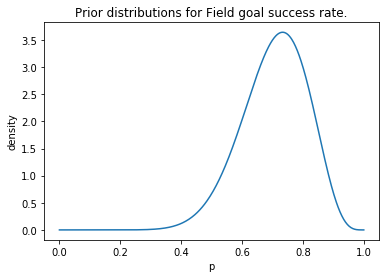

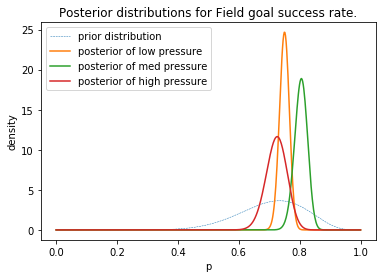

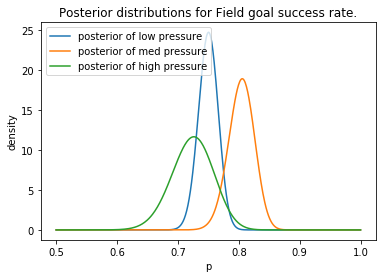

In [64]:
from util.bayes import BetaBinomial

# setup random variables
low = BetaBinomial(alpha_, beta_, 'low pressure')
medium = BetaBinomial(alpha_, beta_, 'med pressure')
high = BetaBinomial(alpha_, beta_, 'high pressure')
low.plot_prior(show=True)
plt.cla()

# update prior
low.observe(df_low['good'])
medium.observe(df_med['good'])
high.observe(df_high['good'])

# plot posterior
low.plot_posterior(prior=True)
medium.plot_posterior(prior=False)
high.plot_posterior(prior=False, show=True)

# zoom in
x = np.linspace(0.5,1,500)
low.plot_posterior(x, prior=False)
medium.plot_posterior(x, prior=False)
high.plot_posterior(x, prior=False, show=True)

# sample from posterior
samples = 20000
samples_posterior_low = low.sample(samples)
samples_posterior_med = medium.sample(samples)
samples_posterior_high = high.sample(samples)

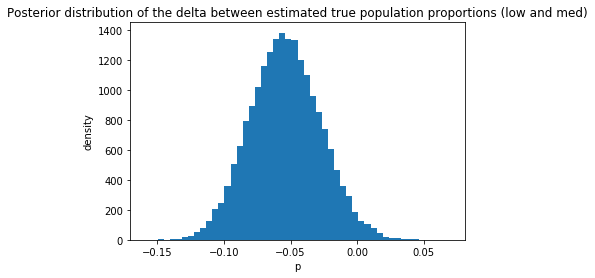

2 % likely that low pressure has a higher true population proportion of converted field goals than medium pressure.
-0.05 is the median difference, with a 50% credible interval of (0.0,-0.11).


In [65]:
posterior_diff = samples_posterior_low - samples_posterior_med

plt.hist(posterior_diff, histtype='stepfilled', bins=50)
plt.xlabel('p')
plt.ylabel('density')
plt.title('Posterior distribution of the delta between estimated true population proportions (low and med)')
plt.show()
print(int((samples_posterior_low>samples_posterior_med).mean()*100), r'% likely that low pressure has a higher true population proportion of converted field goals than medium pressure.')

from scipy.stats import bayes_mvs
alpha = 0.5
center, _, _ = bayes_mvs(posterior_diff, alpha=alpha)
print(f'{round(center.statistic,2)} is the median difference, with a {int(alpha*100)}% credible interval of ({round(center.statistic-center.minmax[0],2)},{round(center.statistic+center.minmax[-1],2)}).')

95 % likely relative lift of medium over low pressure kicks greater than 1%.
0.07 is the median relative lift, with a 50% credible interval of (0.0,0.15).


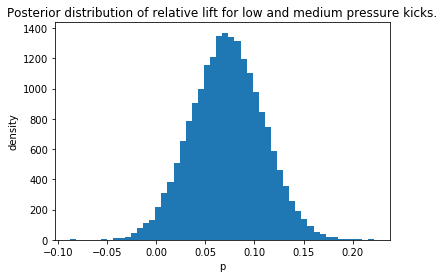

In [66]:
posterior_relative = (samples_posterior_med-samples_posterior_low)/samples_posterior_low
plt.hist(posterior_relative, histtype='stepfilled', bins=50)
plt.xlabel('p')
plt.ylabel('density')
plt.title('Posterior distribution of relative lift for low and medium pressure kicks.')
print(int((posterior_relative>0.01).mean()*100), r'% likely relative lift of medium over low pressure kicks greater than 1%.')

center, _, _ = bayes_mvs(posterior_relative, alpha=alpha)
print(f'{round(center.statistic,2)} is the median relative lift, with a {int(alpha*100)}% credible interval of ({round(center.statistic-center.minmax[0],2)},{round(center.statistic+center.minmax[-1],2)}).')

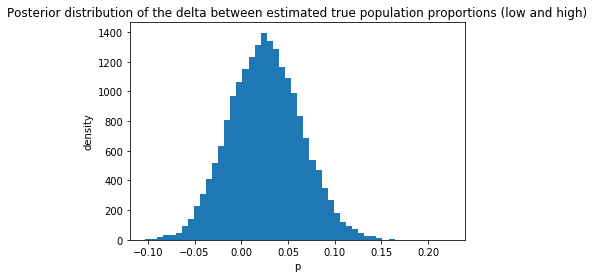

74 % likely that low pressure has a higher true population proportion of converted field goals than high pressure.
0.03 is the median difference, with a 50% credible interval of (0.0,0.05).


In [67]:
posterior_diff = samples_posterior_low - samples_posterior_high

plt.hist(posterior_diff, histtype='stepfilled', bins=50)
plt.xlabel('p')
plt.ylabel('density')
plt.title('Posterior distribution of the delta between estimated true population proportions (low and high)')
plt.show()
print(int((samples_posterior_low>samples_posterior_high).mean()*100), r'% likely that low pressure has a higher true population proportion of converted field goals than high pressure.')

center, _, _ = bayes_mvs(posterior_diff, alpha=alpha)
print(f'{round(center.statistic,2)} is the median difference, with a {int(alpha*100)}% credible interval of ({round(center.statistic-center.minmax[0],2)},{round(center.statistic+center.minmax[-1],2)}).')

19 % likely relative lift of high over low pressure kicks greater than 1%.
-0.03 is the median relative lift, with a 50% credible interval of (0.0,-0.07).


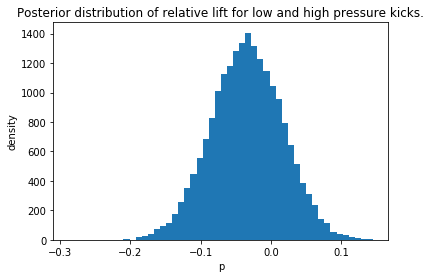

In [68]:
posterior_relative = (samples_posterior_high-samples_posterior_low)/samples_posterior_low
plt.hist(posterior_relative, histtype='stepfilled', bins=50)
plt.xlabel('p')
plt.ylabel('density')
plt.title('Posterior distribution of relative lift for low and high pressure kicks.')
print(int((posterior_relative>0.01).mean()*100), r'% likely relative lift of high over low pressure kicks greater than 1%.')

center, _, _ = bayes_mvs(posterior_relative, alpha=alpha)
print(f'{round(center.statistic,2)} is the median relative lift, with a {int(alpha*100)}% credible interval of ({round(center.statistic-center.minmax[0],2)},{round(center.statistic+center.minmax[-1],2)}).')